Want to make better PS1 image scenes for TESSS

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

In [3]:
def Get_PS1(RA, DEC,Size, filt='i'):
    '''
    Size limit seems to be around 1000
    '''
    if Size > 30:
        raise ValueError('Thats too big man')
    Scale = 100
    size = Size * Scale#int((Size + 2*np.sqrt(1/2)*Size) * Scale ) # last term is a fudge factor 
    fitsurl = sd.geturl(RA,DEC, size=size, filters=filt, format="fits")
    if len(fitsurl) > 0:
        fh = sd.fits.open(fitsurl[0])
        return fh[0]
        ps = fh[0].data
        ps_wcs = sd.WCS(fh[0])
        return ps, ps_wcs
    else:
        raise ValueError("No PS1 images at for this coordinate") 
        return 

In [4]:
# SN2020amx
ra = 148.5706917	
dec = 51.68126944
size = 11
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
# host
ra = 189.1428830     
dec = 11.2386300
#ps, pswcs = Get_PS1(ra,dec,size)

In [5]:
pbs = ['r','i','z','y']
factor = [0.677,0.975,0.977,0.673]
# factors from colour fitting
factor = [0.41656058, 1.12264514, 0.95252585, 0.76186266]

In [93]:
def Combined_image(RA,DEC,Size,pbs,Coeff):
    flux = 0
    for i in range(len(pbs)):
        f = Get_PS1(RA,DEC,Size, filt=pbs[i])
        #zp =f.header['FPA.ZP']
        #mag = -2.5*np.log10(f.data) + zp
        #flux = 10**(-1/2.5*(mag+48.6)) 
        ff = f.data
        ff[ff<0] = 0
        flux += ff * Coeff[i]
    T = flux#-2.5*np.log10(flux) - 48.6
    #T = 10**(-1/2.5*(m-20.44))
    ps_wcs = sd.WCS(f)
    return T, ps_wcs

def Simple_image(RA,DEC,Size):
    flux = 0
    f = Get_PS1(RA,DEC,Size, filt='g')
    zp =f.header['FPA.ZP']
    g = -2.5*np.log10(f.data) + zp
    f = Get_PS1(RA,DEC,Size, filt='i')
    zp =f.header['FPA.ZP']
    i = -2.5*np.log10(f.data) + zp
    T = i - 0.00206*(g - i)**3 - 0.02370*(g - i)**2 + 0.00573*(g - i) - 0.3078
    ps_wcs = sd.WCS(f)
    return T, ps_wcs


In [94]:
com,wcs = Combined_image(ra,dec,size,pbs,factor)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [55]:
np.nanmin(com)

0.0

In [149]:
com,wcs = Simple_image(ra,dec,size)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [8]:
tpf = sd.Get_TESS(ra,dec,12)

In [9]:
def Get_TESS_corners(TESS,PS1_wcs):
    x,y = TESS.flux.shape[1:]
    # include the top corners for the last pixels
    x += 1; y += 1

    corners = np.zeros((2,x,y))
    ps_corners = np.zeros((2,x,y))
    x_arr = np.arange(0,x)
    y_arr = np.arange(0,y)

    for i in range(x):
        for j in range(y):
            corners[:,i,j] = sd.pix2coord(x_arr[i],y_arr[j],TESS.wcs)
            ps_corners[:,i,j] = sd.coord2pix(corners[0,i,j],corners[1,i,j],PS1_wcs)
            
    return ps_corners

tess_corners = Get_TESS_corners(tpf, wcs)

In [10]:
f = 10**(-1/2.5*(T-20.44))

<IPython.core.display.Javascript object>


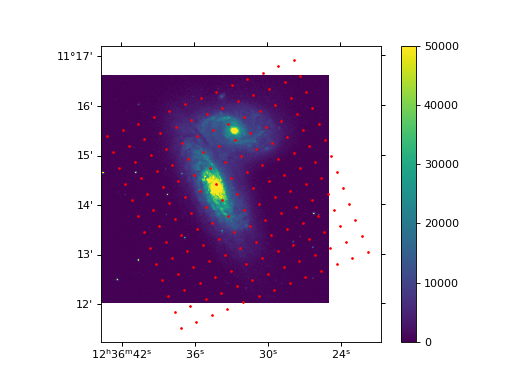

In [29]:
plt.figure()
plt.subplot(projection=wcs)
plt.imshow(com,origin='lower',vmax=50000,vmin=0)
plt.colorbar()
#z = np.arange(0,x*y,1)
plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c='r',s=2)

In [59]:
np.nanmin(com)

0.0

In [12]:
def Regrid_PS(PS1, Corners):
    dim1, dim2 = Corners.shape[1:]
    dim1 -= 1; dim2 -= 1
    global px, py
    px, py = np.where(PS1)
    global squares
    squares = np.array(sd.Make_squares(Corners))
    print(squares)
    square_num = np.arange(0,len(squares))

    points = np.zeros((len(px),2))
    points[:,0] = px
    points[:,1] = py

    global pspixels
    pspixels = sd.Footprint_square(Corners, points)

    global psimage
    psimage = PS1.copy()

    pool = sd.MultiPool()
    values = list(pool.map(sd.Pix_sum, square_num))
    pool.close()

    PS_scene = np.array(values)
    PS_scene = np.nansum(PS_scene,axis=0)
    PS_scene = PS_scene.astype('float')
    PS_scene = PS_scene.reshape(dim1,dim2)
    return PS_scene.T

In [95]:
ps1_scene = sd.Regrid_PS(com,tess_corners)
print(np.nanmin(ps1_scene))
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)
ps1_scene_c = sd.signal.fftconvolve(ps1_scene, PRF, mode='same')

0.0


In [62]:
np.nanmin(ps1_scene_c)

23484.72074825177

In [14]:
from astropy.visualization import (SqrtStretch, ImageNormalize)

<IPython.core.display.Javascript object>


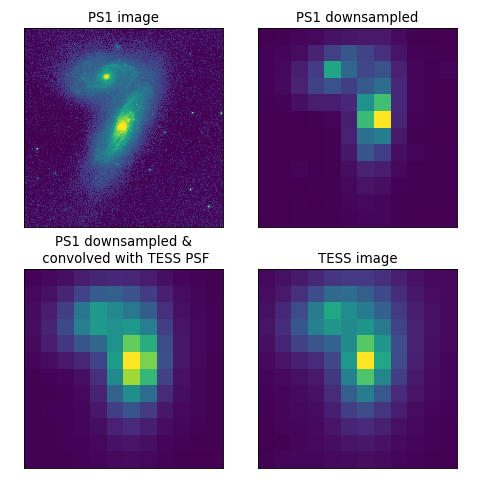

In [15]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.title('PS1 image')
ff= f.copy()
ff[np.isnan(ff)] = 0
norm = ImageNormalize(vmin=0, 
                      vmax=800, stretch=SqrtStretch())
plt.imshow(np.fliplr(ff),origin='',norm=norm)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(222)
plt.title('PS1 downsampled')
plt.imshow(ps1_scene.T,origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(223)
plt.title('PS1 downsampled &\n convolved with TESS PSF')
plt.imshow(ps1_scene_c.T,origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(224)
plt.title('TESS image')
plt.imshow(tpf.flux[100],origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('ngc4568_syndiff.pdf')

In [64]:
np.nanmin(ps1_scene_c)

23484.72074825177

<IPython.core.display.Javascript object>


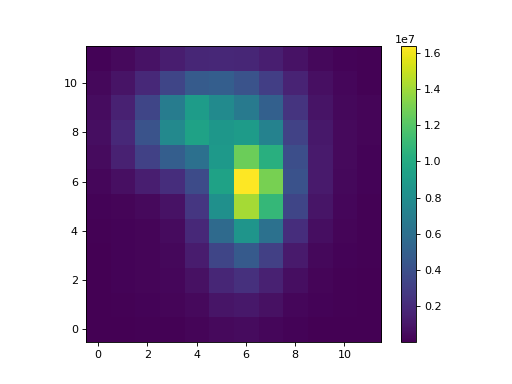

In [101]:
nps1 = ps1_scene_c.T #/ np.nanmax(ps1_scene_c)
ntess = tpf.flux[100]  #/ np.nanmax(tpf.flux[100]) -.32
plt.figure()
plt.imshow(nps1,origin='')
plt.colorbar()

In [71]:
t = np.nanmedian(tpf.flux,axis=0) #- np.nanmin(tpf.flux,axis=(1,2))[:,np.newaxis,np.newaxis]
t = t - np.nanmin(t)

In [72]:
t

array([[   8.91716  ,   16.423218 ,   15.561813 ,   14.8003235,
          24.85405  ,   39.029327 ,   46.675995 ,   33.96399  ,
          17.819733 ,    7.6691284,    2.6182709,    0.       ],
       [   1.6383362,    6.8330994,   12.950485 ,   21.326492 ,
          41.797577 ,   74.55411  ,   88.03664  ,   61.6476   ,
          30.733704 ,   13.744049 ,    4.9756317,    1.4266052],
       [   3.2856293,   13.245056 ,   14.664825 ,   26.159988 ,
          67.06496  ,  136.97246  ,  165.89702  ,  115.26213  ,
          54.823944 ,   23.758041 ,    8.969559 ,    2.7800598],
       [   6.362152 ,   15.223648 ,   19.697113 ,   37.45511  ,
         107.58818  ,  247.7152   ,  307.31567  ,  210.39003  ,
          97.32808  ,   40.275604 ,   15.6306   ,    6.8393707],
       [  14.415253 ,   20.17987  ,   29.462616 ,   55.459366 ,
         155.5345   ,  402.92126  ,  602.1901   ,  371.52966  ,
         159.59749  ,   64.63248  ,   23.04245  ,    9.650497 ],
       [  23.175858 ,   31.709473 ,

<IPython.core.display.Javascript object>


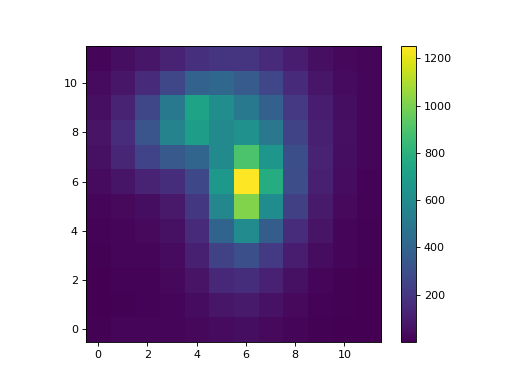

In [74]:
plt.figure()
plt.imshow(t+.01,origin='')
plt.colorbar()

In [102]:
sub = nps1 - npnps1[0,-1]

In [103]:
np.nanmin(sub)

-16476.339192038417

In [105]:
scale = (sub / t).flatten()

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [106]:
scale.flatten

<function ndarray.flatten>

<IPython.core.display.Javascript object>


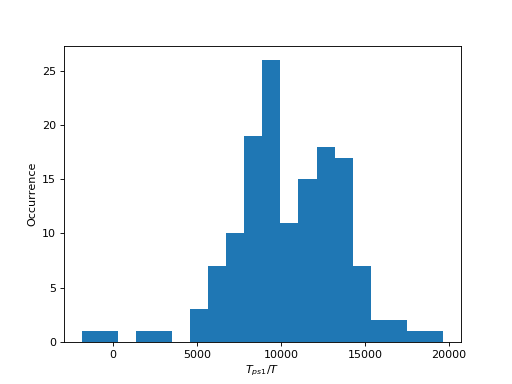

In [279]:
plt.figure()
plt.hist(scale,bins=20);
plt.ylabel('Occurrence')
plt.xlabel('$T_{ps1} / T$')
plt.savefig('scale_distribution.pdf')

<IPython.core.display.Javascript object>


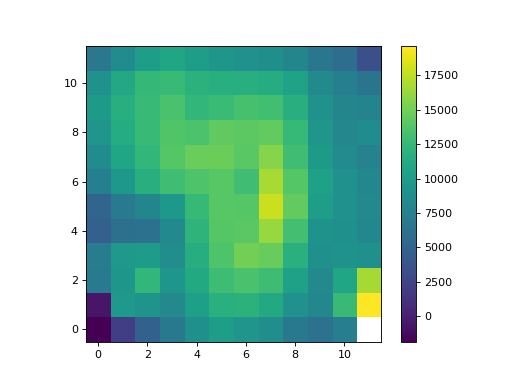

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [108]:
plt.figure()
plt.imshow((sub / (t)),origin='')
plt.colorbar()

In [118]:
np.where(np.nanmax(t) == t)

(array([6]), array([6]))

In [268]:
10**(-2/5 *(23-25))

6.309573444801933

## Look at how the colours map over the image region

In [157]:
g = Get_PS1(ra,dec,size,filt='g').data
g[g<0] = np.nan
g = -2.5*np.log10(g) + 25
g[g>21] = np.nan
r = Get_PS1(ra,dec,size,filt='r').data
r[r<0] = np.nan
r = -2.5*np.log10(r) + 25
r[r>21] = np.nan
i = Get_PS1(ra,dec,size,filt='i').data
i[i<0] = np.nan
i = -2.5*np.log10(i) + 25
i[i>21] = np.nan

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


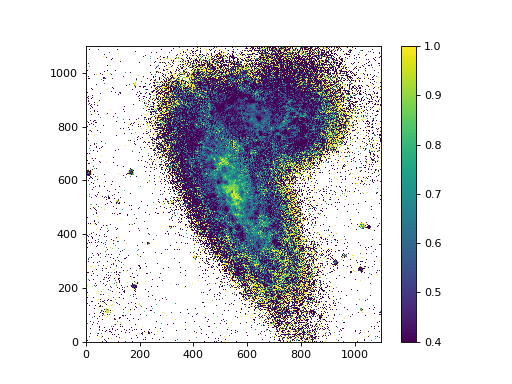

In [158]:
plt.figure()
thing = g-r 
#thing[np.isnan(thing)] = 0
plt.imshow(thing,origin='',vmin=0.4,vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


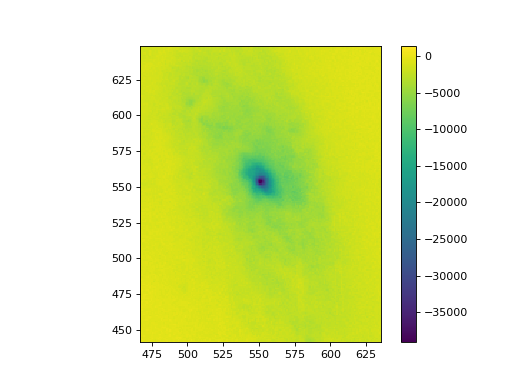

In [151]:
plt.figure()
thing = g-r 
#thing[np.isnan(thing)] = 0
plt.imshow(thing,origin='')
plt.colorbar()

In [164]:
ps1_g= sd.Regrid_PS(g,tess_corners)
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)
ps1_g_c = sd.signal.fftconvolve(ps1_g, PRF, mode='same').T

ps1_r= sd.Regrid_PS(r,tess_corners)
r_c = sd.signal.fftconvolve(ps1_r, PRF, mode='same').T

<IPython.core.display.Javascript object>


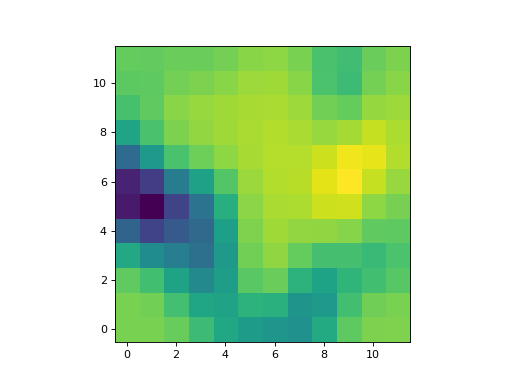

In [165]:
plt.figure()
plt.imshow(ps1_g_c-ps1_r_c,origin='')

In [169]:
colours = (-2.5*np.log10(ps1_g_c)+2.5*np.log10(ps1_r_c) ).flatten()

<IPython.core.display.Javascript object>


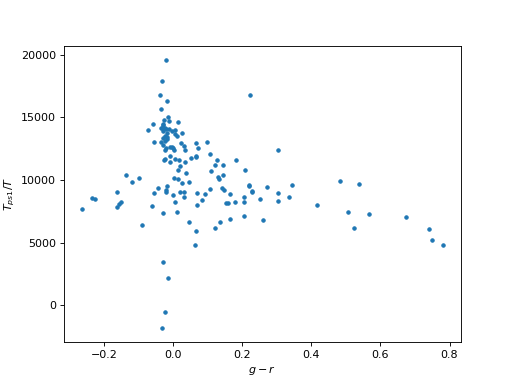

In [278]:
plt.figure()
plt.plot(colours,scale,'.')
plt.xlabel('$g - r$')
plt.ylabel('$T_{ps1} / T$')
plt.savefig('scalefactor_colour.pdf')

In [269]:
g = Get_PS1(ra,dec,size,filt='g').data
g[g<10] = np.nan
r = Get_PS1(ra,dec,size,filt='r').data
r[r<10] = np.nan
i = Get_PS1(ra,dec,size,filt='i').data
i[i<10] = np.nan
z = Get_PS1(ra,dec,size,filt='z').data
z[z<10] = np.nan
y = Get_PS1(ra,dec,size,filt='y').data
y[y<10] = np.nan

In [270]:
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)

tg = sd.Regrid_PS(g,tess_corners)
tg = sd.signal.fftconvolve(tg, PRF, mode='same').T
tr = sd.Regrid_PS(r,tess_corners)
tr = sd.signal.fftconvolve(tr, PRF, mode='same').T
ti= sd.Regrid_PS(i,tess_corners)
ti = sd.signal.fftconvolve(ti, PRF, mode='same').T
tz= sd.Regrid_PS(z,tess_corners)
tz = sd.signal.fftconvolve(tz, PRF, mode='same').T
ty= sd.Regrid_PS(y,tess_corners)
ty = sd.signal.fftconvolve(ty, PRF, mode='same').T

In [250]:
def Fit_flux(coeffs,ps1,tess):
    combined = np.nansum(coeffs[:,np.newaxis,np.newaxis]*ps1,axis=0)
    combined -= np.nanmin(combined)
    tess[tess<=0] = np.nan
    scale = combined / tess
    
    chi2 = np.nansum((scale - np.nanmedian(scale))**2 / np.nanmedian(scale))
    residual = np.nansum(abs(scale - np.nanmedian(scale)))
    print(np.nansum(abs(combined - tess)))
    return np.nansum(abs(combined - tess))

In [233]:
from scipy.optimize import minimize

In [271]:
coeffs = np.array([.1,.1,.1,.1])
bounds = ((0,1),(0,1),(0,1),(0,1))
ps1 = np.array([tr,ti,tz,ty])

In [254]:
coeffs = np.array([.1,.1,.1,.1,.1])
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
ps1 = np.array([tg,tr,ti,tz,ty])


In [272]:
res = minimize(Fit_flux, coeffs, args=(ps1,t),bounds=bounds)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


41670693.470946446
41670694.27818854
41670694.62804439
41670694.33053742
41670694.81666272
25797.23960876465
25796.432366672307
25796.082510824363
25796.380017781354
25795.893892492946
20822457.023633882
20822457.830875978
20822458.180731826
20822457.883224867
20822458.369350158
2890948.8133900044
2890949.620632097
2890949.970487945
2890949.6729809884
2890950.1591062765
25797.23960876465
25796.432366672307
25796.082510824363
25796.380017781354
25795.893892492946
20822457.023633882
20822457.830875974
20822458.18073182
20822457.883224864
20822458.36935015
2890948.810127121
2890949.617369213
2890949.967225061
2890949.6697181044
2890950.155843393
387416.5371964015
387417.34443849383
387417.69429434184
387417.39678738476
387417.8829126733
38451.653054326875
38452.45979194631
38452.80929322845
38452.5119298363
38452.99764465031
3051.1089710608453
3050.5197480731317
3050.2837490793117
3050.5053416155806
3050.1819876247687
53821.06024838197
53821.86698600141
53822.21648728354
53821.91912389138

In [273]:
res

      fun: 2145.8653268274857
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 285162.24560917, 1494416.57381431,  495756.95361455,
       3266136.67307356])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 425
      nit: 17
   status: 2
  success: False
        x: array([1.11268112e-04, 9.86581955e-05, 5.43113041e-05, 0.00000000e+00])

In [262]:
combined = np.nansum(res.x[:,np.newaxis,np.newaxis]*ps1,axis=0)
combined -= np.nanmin(combined)

<IPython.core.display.Javascript object>


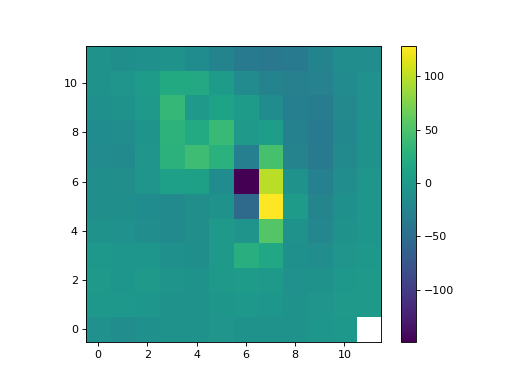

In [265]:
plt.figure()
plt.imshow(combined-t,origin='')
plt.colorbar()

In [274]:
ps1[0]

array([[   5255.05905948,   16410.46035243,   24858.35760687,
          31563.74849707,   68186.43813431,  123261.65406026,
         139932.44696716,   93381.32595164,   37804.699231  ,
          17194.99150297,   10470.67345455,    7128.0927184 ],
       [   9024.13844728,   24940.43186494,   40284.52179947,
          58452.72322553,  130457.65983643,  248708.25734021,
         290048.92273185,  195755.18367484,   78916.37226112,
          31828.61762916,   17999.23675725,   11449.54058235],
       [  15857.44719566,   39764.60698255,   57110.85588683,
          84513.48332177,  220627.41817159,  456713.80224675,
         551225.17561164,  380215.0052516 ,  153471.81858918,
          52630.13805444,   25376.44729406,   15015.20879964],
       [  24064.42227686,   49193.59481399,   64469.13901756,
         109020.93398138,  341994.96718947,  810224.32623856,
        1055789.10120063,  724662.26165693,  281604.20860568,
          86532.85939954,   35150.2262022 ,   18392.45743823],
    